In [1]:
import folium

print(folium.__file__)
print(folium.__version__)

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/folium/__init__.py
0.1.6


In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])

def make_map(bbox, projection=ccrs.Mercator()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.add_feature(LAND, facecolor='0.25')
    ax.coastlines(resolution='50m')
    return fig, ax

In [3]:
import numpy.ma as ma
from scipy.io import loadmat
from oceans.colormaps import cm

merc = loadmat('./data/mercator_temperature.mat', squeeze_me=True)

x, y = merc['x'], merc['y']
bbox = [x.min(), x.max(), y.min(), y.max()]

level = 10  # 10 meters temperature.
data = ma.masked_invalid(merc['temp'][level, ...])

fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(x, y, data, cmap=cm.avhrr, transform=ccrs.PlateCarree())
fig.savefig('GS.png', transparent=True)

In [4]:
import numpy as np
from PIL import Image, ImageChops


def trim(img):
    border = Image.new(img.mode, img.size, img.getpixel((0, 0)))
    diff = ImageChops.difference(img, border)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    return np.array(img)

img = Image.open("GS.png")
img = trim(img)


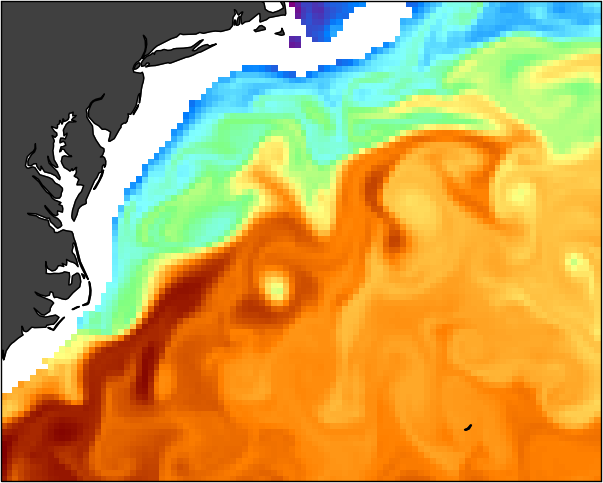

In [5]:
mapa = folium.Map(location=[y.mean(), x.mean()], zoom_start=5)

mapa.image_overlay(img,
                   min_lat=y.min(), max_lat=y.max(),
                   min_lon=x.min(), max_lon=x.max(),
                   image_opacity=0.5)

mapa

Bypass the figure creation entirely:

In [6]:
import matplotlib.pyplot as plt

def colorize(array, cmap='rainbow'):
    normed_data = (array - array.min()) / (array.max() - array.min())
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data)

colored_data = colorize(data, cmap='rainbow')


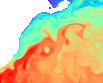

In [7]:
mapa = folium.Map(location=[y.mean(), x.mean()], zoom_start=5)

mapa.image_overlay(np.flipud(colored_data),
                   min_lat=y.min(), max_lat=y.max(),
                   min_lon=x.min(), max_lon=x.max(),
                   image_opacity=0.5)

mapa